In [3]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

In [17]:
season_list = ['1617', '1718', '1819', '1920', '2021', '2122', '2223', '2324', '2425']
league_list = ['E0', 'E1', 'E2', 'E3', 'SC0', 'SC1', 'SC2', 'D1', 'D2', 'I1', 'I2', 'SP1', 'SP2', 'F1', 'F2', 'N1', 'B1', 'P1', 'T1', 'G1'] 


df_list = []
for league in league_list:
    for season in season_list:
        data_url = f'https://www.football-data.co.uk/mmz4281/{season}/{league}.csv'
        try: 
            df = pd.read_csv(data_url)
        except:
            df = pd.read_csv(data_url, encoding = 'latin')
        df_list.append(df)

main_df = pd.concat(df_list)


main_df['Date'] = pd.to_datetime(main_df['Date'], format='mixed')


df = main_df

bet_providers = ['B365', 'BFE', 'BF', 'PS']

home_cols = []
draw_cols = []
away_cols = []

for bet in bet_providers:
    home_cols.append(bet + 'H')
    draw_cols.append(bet + 'D')
    away_cols.append(bet + 'A')


df['home_max_odds'] = df[home_cols].max(axis=1)
df['draw_max_odds'] = df[draw_cols].max(axis=1)
df['away_max_odds'] = df[away_cols].max(axis=1)

col_list = ['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'B365H', 'B365D', 'B365A', 'PSH', 'PSD', 'PSA', 'home_max_odds', 'draw_max_odds', 'away_max_odds']
df = df[col_list]



/var/folders/rt/kk5y63zd2dl20zp4x97pdp2m0000gn/T/ipykernel_15032/2870671597.py:35: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['home_max_odds'] = df[home_cols].max(axis=1)
/var/folders/rt/kk5y63zd2dl20zp4x97pdp2m0000gn/T/ipykernel_15032/2870671597.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['draw_max_odds'] = df[draw_cols].max(axis=1)
/var/folders/rt/kk5y63zd2dl20zp4x97pdp2m0000gn/T/ipykernel_15032/2870671597.py:37: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

In [36]:
def find_true_probabilties_equal(odds):
    probabilities = [1/o for o in odds]
    total_probability = sum(probabilities)
    overround = total_probability -1
    adjustment_factor = overround/len(odds)
    adjusted_probabilities = [(1/o) -adjustment_factor for o in odds]
    return np.array(adjusted_probabilities)

df[['pinnacle_true_home_prob', 'pinnacle_true_draw_prob', 'pinnacle_true_away_prob']] = df.apply(
    lambda row: find_true_probabilties_equal([row['PSH'], row['PSD'], row['PSA']]),
    axis=1,
    result_type='expand'
)

df['totes'] = df['pinnacle_true_home_prob'] + df['pinnacle_true_draw_prob'] + df['pinnacle_true_away_prob']


tolerance = 1e-7
mask = np.abs(df['totes'] - 1) <= tolerance

assert len(df[~mask]) == 0

df = df[~df['pinnacle_true_home_prob'].isna()]
df = df[::-1]
df.head()

,level_0,index,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,B365H,B365D,B365A,PSH,PSD,PSA,home_max_odds,draw_max_odds,away_max_odds,pinnacle_true_home_prob,pinnacle_true_draw_prob,pinnacle_true_away_prob,totes
0,0,205,G1,2025-04-23,Athens Kallithea,Levadeiakos,0.0,3.0,1.90,3.3,4.20,1.91,3.31,4.29,1.93,3.40,4.50,0.503968,0.282523,0.213508,1.0
1,1,204,G1,2025-04-23,Panserraikos,Panetolikos,1.0,1.0,2.10,3.1,3.75,2.07,3.19,3.83,2.15,3.19,3.95,0.463869,0.294257,0.241874,1.0
2,2,203,G1,2025-04-23,Lamia,Volos NFC,1.0,3.0,7.00,4.1,1.48,7.50,3.96,1.48,8.60,4.30,1.50,0.112822,0.232014,0.655164,1.0
3,3,202,G1,2025-04-13,Olympiakos,AEK,1.0,0.0,1.91,3.3,4.20,1.95,3.30,4.11,1.95,3.40,4.20,0.493101,0.283310,0.223589,1.0
4,4,201,G1,2025-04-13,Aris,Atromitos,1.0,0.0,1.73,3.6,5.00,1.68,3.58,5.39,1.73,3.60,5.39,0.575206,0.259297,0.165497,1.0


In [37]:
def calculate_ev_from_odds(bookmaker_odds, our_probability):
    payout = bookmaker_odds
    ev = (our_probability * payout) - 1
    return ev

In [38]:
def calculate_kelley_stake(bankroll, ev, odds, kelly_fraction=0.25):
    if odds <= 1 or kelly_fraction <= 0:
        return 0.0
    stake_fraction = ev / (odds -1)

    if stake_fraction <= 0:
        return 0.0
    
    stake_fraction *= kelly_fraction

    return stake_fraction * bankroll


In [39]:
df['home_ev'] = df.apply(
    lambda row: calculate_ev_from_odds(
        row['home_max_odds'],
        row['pinnacle_true_home_prob']
    ),
    axis = 1
)

<Axes: >

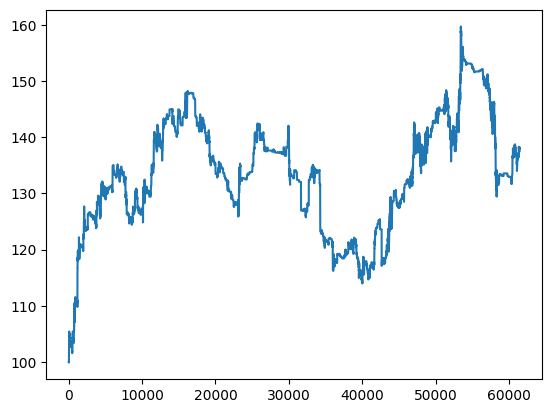

In [41]:
bankroll = 100

for i in range(len(df)):
    bet_size = calculate_kelley_stake(bankroll, df.loc[i]['home_ev'], df.loc[i]['home_max_odds'])
    df.loc[i, 'bet_size'] = bet_size
    bankroll = bankroll - bet_size
    if df.loc[i]['FTHG'] > df.loc[i]['FTAG']:
        bankroll = bankroll + bet_size*df.loc[i]['home_max_odds']

    df.loc[i, 'bankroll'] = bankroll
    
df.bankroll.plot()